# Darwin Mini: ZMP trajectory

Learning from Stephane Caron's introductory article: 
https://scaron.info/teaching/prototyping-a-walking-pattern-generator.html

I would like to create a simple program to determine the optimal COM trajectory such that the ZMP contraints are enforced.  If possible, I don't want to depend on `pymanoid`, because it requires OpenRAVE, which is a pain to install (2h to install on an Ubuntu 18.04 VM!)

I found the following optimizer, which seems to be fit my needs:
https://osqp.org/docs/examples/mpc.html

In [2]:
from numpy import array, zeros

In [3]:
class Point(object):

    """
    Point
    
    pos : array, shape=(3,), optional
        Initial position in the world frame.
    vel : array, shape=(3,), optional
        Initial velocity in the world frame.
    accel : array, shape=(3,), optional
        Initial acceleration in the world frame.
    """

    def __init__(self, pos=None, vel=None, accel=None):
        self.__pos = zeros(3) if pos is None else array(pos)
        self.__pd = zeros(3) if vel is None else array(vel)
        self.__pdd = zeros(3) if accel is None else array(accel)

    def copy(self):
        """
        Copy constructor.
        
        color : char, optional
            Color of the copy, in ['r', 'g', 'b'].
        visible : bool, optional
            Should the copy be visible?
        """
        return Point(self.p, self.pd)

    @property
    def p(self):
        """Position coordinates `[x y z]` in the world frame."""
        return self.__pos.copy()

    @property
    def pos(self):
        """Position coordinates `[x y z]` in the world frame."""
        return self.p

    def set_pos(self, pos):
        """
        Set the position of the body in the world frame.
        
        pos : array, shape=(3,)
            3D vector of position coordinates.
        """
        self.__pos = array(pos)

    @property
    def pd(self):
        """Point velocity."""
        return self.__pd.copy()

    def set_vel(self, pd):
        """
        Update the point velocity.
        
        pd : array, shape=(3,)
            Velocity coordinates in the world frame.
        """
        self.__pd = array(pd)

    @property
    def pdd(self):
        """Point acceleration."""
        return self.__pdd.copy()

    def set_accel(self, pdd):
        """
        Update the point acceleration.
        
        pdd : array, shape=(3,)
            Acceleration coordinates in the world frame.
        """
        self.__pdd = array(pdd)

    def integrate_constant_accel(self, pdd, dt):
        """
        Apply Euler integration for a constant acceleration.
        
        pdd : array, shape=(3,)
            Point acceleration in the world frame.
        dt : scalar
            Duration in [s].
        """
        self.set_pos(self.p + (self.pd + .5 * pdd * dt) * dt)
        self.set_vel(self.pd + pdd * dt)
        self.set_accel(pdd)

    def integrate_constant_jerk(self, pddd, dt):
        """
        Apply Euler integration for a constant jerk.
        
        pddd : array, shape=(3,)
            Point jerk in the world frame.
        dt : scalar
            Duration in [s].
        """
        self.set_pos(self.p + dt * (
            self.pd + .5 * dt * (self.pdd + dt * pddd / 3.)))
        self.set_vel(self.pd + dt * (self.pdd + dt * pddd / 2.))
        self.set_accel(self.pdd + dt * pddd)

In [4]:
def generate_footsteps(distance, step_length, foot_spread):
    footsteps = []

    def append_contact(x, y):
        L = 0.088
        w = 0.048
        footsteps.append([(x + L/2, y + w/2), (x + L/2, y - w/2), (x - L/2, y - w/2), (x - L/2, y + w/2)])

    append_contact(0., +foot_spread)
    append_contact(0., -foot_spread)
    x = 0.
    y = foot_spread
    while x < distance:
        if distance - x <= step_length:
            x += min(distance - x, 0.5 * step_length)
        else:  # still some way to go
            x += step_length
        y = -y
        append_contact(x, y)
    append_contact(x, -y)  # now x == distance
    return footsteps

footsteps = generate_footsteps(distance=1.0, step_length=0.1, foot_spread=0.032)

In [5]:
len(footsteps)

14

In [6]:
dt = 0.03  # simulation time step, in [s]
h = 0.088
com = Point([0., 0., h])

In [ ]:
class WalkingFSM(object):

    def __init__(self, ssp_duration, dsp_duration):
        self.dsp_duration = dsp_duration
        self.mpc_timestep = 3 * dt  # update MPC every 90 [ms] (see below)
        self.next_footstep = 2
        self.ssp_duration = ssp_duration
        self.state = None
        self.start_standing()

    def start_standing(self):
        self.start_walking = False
        self.state = "Standing"
        return self.run_standing()

    def run_standing(self):
        if self.start_walking:
            self.start_walking = False
            if self.next_footstep < len(footsteps):
                return self.start_double_support()

    def start_double_support(self):
        if self.next_footstep % 2 == 1:  # left foot swings
            self.stance_foot = stance.right_foot
        else:  # right foot swings
            self.stance_foot = stance.left_foot
        dsp_duration = self.dsp_duration
        if self.next_footstep == 2 or self.next_footstep == len(footsteps) - 1:
            # double support is a bit longer for the first and last steps
            dsp_duration = 4 * self.dsp_duration
        self.swing_target = footsteps[self.next_footstep]
        self.rem_time = dsp_duration
        self.state = "DoubleSupport"
        self.start_com_mpc_dsp()
        return self.run_double_support()

    def run_double_support(self):
        if self.rem_time <= 0.:
            return self.start_single_support()
        self.run_com_mpc()
        self.rem_time -= dt

    def start_com_mpc_dsp(self):
        self.update_mpc(self.rem_time, self.ssp_duration)

    def run_com_mpc(self):
        stance.com.set_x(0.5 * (self.swing_foot.x + self.stance_foot.x))

    def start_single_support(self):
        if self.next_footstep % 2 == 1:  # left foot swings
            self.swing_foot = stance.free_contact('left_foot')
        else:  # right foot swings
            self.swing_foot = stance.free_contact('right_foot')
        self.next_footstep += 1
        self.rem_time = self.ssp_duration
        self.state = "SingleSupport"
        self.start_swing_foot()
        self.start_com_mpc_ssp()
        self.run_single_support()

    def run_single_support(self):
        if self.rem_time <= 0.:
            stance.set_contact(self.swing_foot)
            if self.next_footstep < len(footsteps):
                return self.start_double_support()
            else:  # footstep sequence is over
                return self.start_standing()
        self.run_swing_foot()
        self.run_com_mpc()
        self.rem_time -= dt

    def start_swing_foot(self):
        self.swing_start = self.swing_foot.pose
        self.swing_interp = SwingFoot(
            self.swing_foot, self.swing_target, ssp_duration,
            takeoff_clearance=0.05, landing_clearance=0.05)

    def start_com_mpc_ssp(self):
        self.update_mpc(0., self.rem_time)

    def run_swing_foot(self):
        new_pose = self.swing_interp.integrate(dt)
        self.swing_foot.set_pose(new_pose)

    def on_tick(self, sim):
        if self.state == "Standing":
            return self.run_standing()
        elif self.state == "DoubleSupport":
            return self.run_double_support()
        elif self.state == "SingleSupport":
            return self.run_single_support()
        raise Exception("Unknown state: " + self.state)

    def update_mpc(self, dsp_duration, ssp_duration):
        nb_preview_steps = 16
        T = self.mpc_timestep
        nb_init_dsp_steps = int(round(dsp_duration / T))
        nb_init_ssp_steps = int(round(ssp_duration / T))
        nb_dsp_steps = int(round(self.dsp_duration / T))
        A = array([[1., T, T ** 2 / 2.], [0., 1., T], [0., 0., 1.]])
        B = array([T ** 3 / 6., T ** 2 / 2., T]).reshape((3, 1))
        h = com.p[2]  # z
        g = -9.8  # m/s2
        zmp_from_state = array([1., 0., -h / g])
        C = array([+zmp_from_state, -zmp_from_state])
        D = None
        e = [[], []]
        cur_vertices = self.stance_foot.get_scaled_contact_area(0.8)
        next_vertices = self.swing_target.get_scaled_contact_area(0.8)
        for coord in [0, 1]:
            cur_max = max(v[coord] for v in cur_vertices)
            cur_min = min(v[coord] for v in cur_vertices)
            next_max = max(v[coord] for v in next_vertices)
            next_min = min(v[coord] for v in next_vertices)
            e[coord] = [
                array([+1000., +1000.]) if i < nb_init_dsp_steps else
                array([+cur_max, -cur_min]) if i - nb_init_dsp_steps <= nb_init_ssp_steps else
                array([+1000., +1000.]) if i - nb_init_dsp_steps - nb_init_ssp_steps < nb_dsp_steps else
                array([+next_max, -next_min])
                for i in range(nb_preview_steps)]
        self.x_mpc = LinearPredictiveControl(
            A, B, C, D, e[0],
            x_init=array([stance.com.x, stance.com.xd, stance.com.xdd]),
            x_goal=array([self.swing_target.x, 0., 0.]),
            nb_steps=nb_preview_steps,
            wxt=1., wu=0.01)
        self.y_mpc = LinearPredictiveControl(
            A, B, C, D, e[1],
            x_init=array([stance.com.y, stance.com.yd, stance.com.ydd]),
            x_goal=array([self.swing_target.y, 0., 0.]),
            nb_steps=nb_preview_steps,
            wxt=1., wu=0.01)
        self.x_mpc.solve()
        self.y_mpc.solve()
        self.preview_time = 0.

    def run_com_mpc(self):
        if self.preview_time >= self.mpc_timestep:
            if self.state == "DoubleSupport":
                self.update_mpc(self.rem_time, self.ssp_duration)
            else:  # self.state == "SingleSupport":
                self.update_mpc(0., self.rem_time)
        com_jerk = array([self.x_mpc.U[0][0], self.y_mpc.U[0][0], 0.])
        stance.com.integrate_constant_jerk(com_jerk, dt)
        self.preview_time += dt


In [1]:
from darwin_mini.trajectory import FootstepTrajectory

In [2]:
traj = FootstepTrajectory(0.1, .005, .05, 0., .088, 'l', 1.)

In [3]:
t1 = [traj(t) for t in [.0, .25, .5, .75, 1.]]

Positions at time 0.000:
  pelvis: (0.025, 0.000, 0.084)
  l_foot: (0.000, 0.320, 0.000)
  r_foot: (0.050, -0.320, 0.000)
stable foot vs pelvis:  dx=-0.0250, dy=0.0000, dz=0.0336
swing foot vs pelvis:   dx=0.0250, dy=0.0000, dz=0.0336, z_foot=0.0000
Positions at time 0.250:
  pelvis: (0.033, 0.000, 0.086)
  l_foot: (0.016, 0.320, 0.004)
  r_foot: (0.050, -0.320, 0.000)
stable foot vs pelvis:  dx=-0.0172, dy=0.0000, dz=0.0317
swing foot vs pelvis:   dx=0.0172, dy=0.0000, dz=0.0279, z_foot=0.0037
Positions at time 0.500:
  pelvis: (0.050, 0.000, 0.088)
  l_foot: (0.050, 0.320, 0.005)
  r_foot: (0.050, -0.320, 0.000)
stable foot vs pelvis:  dx=-0.0000, dy=0.0000, dz=0.0300
swing foot vs pelvis:   dx=-0.0000, dy=0.0000, dz=0.0250, z_foot=0.0050
Positions at time 0.750:
  pelvis: (0.067, 0.000, 0.086)
  l_foot: (0.084, 0.320, 0.004)
  r_foot: (0.050, -0.320, 0.000)
stable foot vs pelvis:  dx=0.0172, dy=0.0000, dz=0.0317
swing foot vs pelvis:   dx=-0.0172, dy=0.0000, dz=0.0279, z_foot=0.0037

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pypot.creatures import DarwinMini

darwin = DarwinMini(simulator='dummy')
# darwin = DarwinMini(simulator='vrep')

In [12]:
from darwin_mini.walk import WalkStraight, WalkingState
from darwin_mini.point import Point
from darwin_mini.mpc import LinearPredictiveControl

import numpy as np


FOOT_LENGTH = 0.088
FOOT_WIDTH = 0.048


class ZMPWalking(WalkStraight):

    def __init__(self, robot, distance, step_duration, frequency=50):
        WalkStraight.__init__(self, robot, distance, step_duration, frequency)
        
        self.mpc_timestep = 3 * self.dt
        self.preview_time = self.mpc_timestep  # to force MPC update at start
        self.com = Point()
        # for plotting later
        self.points = []
        self.footsteps = []

    def get_support_bounds(self):
        l, w = FOOT_LENGTH, FOOT_WIDTH
        L = (1. if self.current_step == 0 else 0.5) * self.current_step_length
        stable_foot_pos = self.pos[self.stable_side + '_foot']
        cur_min = (stable_foot_pos[0] - l/2, stable_foot_pos[1] - w/2)
        cur_max = (stable_foot_pos[0] + l/2, stable_foot_pos[1] + w/2)
        next_min = (stable_foot_pos[0] + L - l/2, -stable_foot_pos[1] - w/2)
        next_max = (stable_foot_pos[0] + L + l/2, -stable_foot_pos[1] + w/2)
        return cur_min, cur_max, next_min, next_max

    def update_mpc(self, dsp_duration, ssp_duration):
        print("update_mpc(): dsp_duration={}, ssp_duration={}".format(dsp_duration, ssp_duration))
        nb_preview_steps = 16
        T = self.mpc_timestep
        nb_init_dsp_steps = int(round(dsp_duration / T))
        nb_init_ssp_steps = int(round(ssp_duration / T))
        nb_dsp_steps = int(round(self.dsp_duration / T))
        A = np.array([[1., T, T ** 2 / 2.], [0., 1., T], [0., 0., 1.]])
        B = np.array([T ** 3 / 6., T ** 2 / 2., T]).reshape((3, 1))
        h = self.com.p[2]  # z
        g = 9.80665  # m/s2 (ISO 80000-3)
        zmp_from_state = np.array([1., 0., -h / g])
        C = np.array([zmp_from_state, -zmp_from_state])
        D = None
        e = [[], []]
        cur_min, cur_max, next_min, next_max = self.get_support_bounds()
        # print("  update_mpc(): cur_min={}, cur_max={}, next_min={}, next_max={}".format(
        #     cur_min, cur_max, next_min, next_max))
        for k in [0, 1]:
            e[k] = [
                np.array([1000., 1000.]) if i < nb_init_dsp_steps else
                np.array([cur_max[k], -cur_min[k]]) if i - nb_init_dsp_steps <= nb_init_ssp_steps else
                np.array([1000., 1000.]) if i - nb_init_dsp_steps - nb_init_ssp_steps < nb_dsp_steps else
                np.array([next_max[k], -next_min[k]])
                for i in range(nb_preview_steps)]
        print("  update_mpc(): e = {}".format(e))
        if self.current_step >= len(self.footsteps):
            self.footsteps.append(self.swing_target[:2])
        print("update_mpc(): com=({:.3f},{:.3f}), target=({:.3f}, {:.3f})".format(
            self.com.p[0], self.com.p[1], self.swing_target[0], self.swing_target[1]))
        self.x_mpc = LinearPredictiveControl(
            A, B, C, D, e[0],
            x_init=np.array([self.com.p[0], self.com.pd[0], self.com.pdd[0]]),
            x_goal=np.array([self.swing_target[0], 0., 0.]),
            nb_steps=nb_preview_steps,
            wxt=1., wu=0.01)
        self.y_mpc = LinearPredictiveControl(
            A, B, C, D, e[1],
            x_init=np.array([self.com.p[1], self.com.pd[1], self.com.pdd[1]]),
            x_goal=np.array([self.swing_target[1], 0., 0.]),
            nb_steps=nb_preview_steps,
            wxt=1., wu=0.01)
        self.x_mpc.solve()
        self.y_mpc.solve()
        self.preview_time = 0.

    def run_com_mpc(self, t):
        p = np.array(self.pos['pelvis'])
        p[0] = self.com.p[0]  # keep x
        p[1] = self.com.p[1]  # keep y
        self.com.set_pos(p)
        if self.preview_time >= self.mpc_timestep:
            if self.state == WalkingState.DOUBLE_SUPPORT:
                self.update_mpc(self.dsp_duration - t, self.ssp_duration)
            else:  # self.state == WalkingState.SINGLE_SUPPORT:
                self.update_mpc(0., self.step_duration - t)
        com_jerk = [self.x_mpc.U[0][0], self.y_mpc.U[0][0], 0.]
        print("run_com_mpc(): com_jerk = {}".format(com_jerk))
        if None not in com_jerk:
            self.com.integrate_constant_jerk(np.array(com_jerk), self.dt)
            print("run_com_mpc(): com = {}".format(self.com.p))
            self.points.append(self.com.p[:2])
        else:
            self.points.append([self.com.p[0], np.nan])
        self.preview_time += self.dt

    def update_position(self, t):
        super().update_position(t)
        self.run_com_mpc(t)

In [17]:
w = ZMPWalking(darwin, 1.0, 1.0)

w.start()


*** Start step 1 ***
 >> start double support phase <<
Positions at time 0.750:
  pelvis: (0.025, 0.000, 0.095)
  l_foot: (0.000, 0.032, 0.000)
  r_foot: (0.050, -0.032, 0.000)
Positions at time 0.000:
  pelvis: (0.000, 0.000, 0.118)
  l_foot: (0.000, 0.032, 0.000)
  r_foot: (0.000, -0.032, 0.000)
update_mpc(): dsp_duration=0.24996304512023926, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044])], [array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), 

Positions at time 0.414:
  pelvis: (0.014, 0.000, 0.097)
  l_foot: (0.000, 0.032, 0.000)
  r_foot: (0.029, -0.032, 0.010)
update_mpc(): dsp_duration=0.0, ssp_duration=0.5859620571136475
  update_mpc(): e = [[array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.094, -0.006]), array([ 0.094, -0.006])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.008,  0.056]), array([-0.008,  0.056])]]
update_mpc(): com=(0.00

Positions at time 0.829:
  pelvis: (0.024, 0.000, 0.095)
  l_foot: (0.000, 0.032, 0.000)
  r_foot: (0.048, -0.032, -0.005)
update_mpc(): dsp_duration=0.0, ssp_duration=0.17124009132385254
  update_mpc(): e = [[array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([0.044, 0.044]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056])]]
update_

Positions at time 0.242:
  pelvis: (0.016, 0.000, 0.097)
  l_foot: (0.000, 0.032, 0.000)
  r_foot: (0.031, -0.032, -0.017)
update_mpc(): dsp_duration=0.007888078689575195, ssp_duration=0.75
  update_mpc(): e = [[array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([0.07510282, 0.01289718]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.])], [array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008

Positions at time 0.653:
  pelvis: (0.073, 0.000, 0.095)
  l_foot: (0.095, 0.032, 0.005)
  r_foot: (0.050, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.34703588485717773
  update_mpc(): e = [[array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([ 0.094, -0.006]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056])], [array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008])]]


Positions at time 0.074:
  pelvis: (0.056, 0.000, 0.098)
  l_foot: (0.063, 0.032, -0.017)
  r_foot: (0.050, -0.032, 0.000)
run_com_mpc(): com_jerk = [-0.41925859555336836, -0.4132389591461281, 0.0]
run_com_mpc(): com = [ 0.04066093 -0.00302356  0.09778778]
Positions at time 0.098:
  pelvis: (0.056, 0.000, 0.098)
  l_foot: (0.063, 0.032, -0.017)
  r_foot: (0.050, -0.032, 0.000)
update_mpc(): dsp_duration=0.15218877792358398, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175]), array([ 0.10689175, -0.01889175])], [array(

Positions at time 0.498:
  pelvis: (0.112, 0.000, 0.097)
  l_foot: (0.100, 0.032, 0.000)
  r_foot: (0.124, -0.032, 0.009)
run_com_mpc(): com_jerk = [-0.11316262269466323, 1.0385569862451103, 0.0]
run_com_mpc(): com = [0.07128518 0.00899363 0.09727505]
Positions at time 0.523:
  pelvis: (0.114, 0.000, 0.097)
  l_foot: (0.100, 0.032, 0.000)
  r_foot: (0.128, -0.032, 0.008)
update_mpc(): dsp_duration=0.0, ssp_duration=0.4766092300415039
  update_mpc(): e = [[array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.0

Positions at time 0.925:
  pelvis: (0.116, 0.000, 0.097)
  l_foot: (0.100, 0.032, 0.000)
  r_foot: (0.131, -0.032, -0.012)
update_mpc(): dsp_duration=0.0, ssp_duration=0.0747690200805664
  update_mpc(): e = [[array([ 0.144, -0.056]), array([ 0.144, -0.056]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056])]]


Positions at time 0.343:
  pelvis: (0.147, 0.000, 0.098)
  l_foot: (0.144, 0.032, 0.010)
  r_foot: (0.150, -0.032, 0.000)
run_com_mpc(): com_jerk = [0.03297570455520858, 1.7483045988165717, 0.0]
run_com_mpc(): com = [ 0.12433694 -0.01649004  0.09794853]
Positions at time 0.365:
  pelvis: (0.149, 0.000, 0.098)
  l_foot: (0.148, 0.032, 0.010)
  r_foot: (0.150, -0.032, 0.000)
run_com_mpc(): com_jerk = [0.03297570455520858, 1.7483045988165717, 0.0]
run_com_mpc(): com = [ 0.12538049 -0.0180751   0.09799508]
Positions at time 0.390:
  pelvis: (0.152, 0.000, 0.098)
  l_foot: (0.153, 0.032, 0.010)
  r_foot: (0.150, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.6098859310150146
  update_mpc(): e = [[array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([10

Positions at time 0.762:
  pelvis: (0.175, 0.000, 0.095)
  l_foot: (0.200, 0.032, -0.001)
  r_foot: (0.150, -0.032, 0.000)
run_com_mpc(): com_jerk = [0.03656010021628508, 0.5504632614369436, 0.0]
run_com_mpc(): com = [ 0.14082213 -0.03191172  0.09476721]
Positions at time 0.783:
  pelvis: (0.175, 0.000, 0.095)
  l_foot: (0.199, 0.032, -0.002)
  r_foot: (0.150, -0.032, 0.000)
run_com_mpc(): com_jerk = [0.03656010021628508, 0.5504632614369436, 0.0]
run_com_mpc(): com = [ 0.1416104  -0.03154155  0.09483461]
Positions at time 0.808:
  pelvis: (0.174, 0.000, 0.095)
  l_foot: (0.198, 0.032, -0.003)
  r_foot: (0.150, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.1921830177307129
  update_mpc(): e = [[array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([ 0.194, -0.106]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.244, -0.156]), array([ 0.244, -0.156]), array([ 0.244, -0.156]), array([ 0.244, -0.156]), array([ 0.24

Positions at time 0.203:
  pelvis: (0.158, 0.000, 0.098)
  l_foot: (0.165, 0.032, -0.016)
  r_foot: (0.150, -0.032, 0.000)
update_mpc(): dsp_duration=0.04670310020446777, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([ 0.20923361, -0.12123361]), array([1000., 1000.]), array([1000., 1000.])], [array([1000., 1000.]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, 

Positions at time 0.620:
  pelvis: (0.221, 0.000, 0.096)
  l_foot: (0.200, 0.032, 0.000)
  r_foot: (0.242, -0.032, 0.006)
run_com_mpc(): com_jerk = [0.10641635881466294, -0.3692341029536852, 0.0]
run_com_mpc(): com = [0.16731159 0.03872397 0.09571892]
Positions at time 0.640:
  pelvis: (0.222, 0.000, 0.095)
  l_foot: (0.200, 0.032, 0.000)
  r_foot: (0.244, -0.032, 0.005)
run_com_mpc(): com_jerk = [0.10641635881466294, -0.3692341029536852, 0.0]
run_com_mpc(): com = [0.16816673 0.03939755 0.09547561]
Positions at time 0.661:
  pelvis: (0.223, 0.000, 0.095)
  l_foot: (0.200, 0.032, 0.000)
  r_foot: (0.246, -0.032, 0.004)
update_mpc(): dsp_duration=0.0, ssp_duration=0.3392069339752197
  update_mpc(): e = [[array([ 0.244, -0.156]), array([ 0.244, -0.156]), array([ 0.244, -0.156]), array([ 0.244, -0.156]), array([ 0.244, -0.156]), array([ 0.244, -0.156]), array([ 0.244, -0.156]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.294, -0.206]), array([ 0.294, -0.2

Positions at time 0.028:
  pelvis: (0.208, 0.000, 0.098)
  l_foot: (0.200, 0.032, 0.000)
  r_foot: (0.215, -0.032, -0.016)
run_com_mpc(): com_jerk = [-0.5523568232111259, 1.9856327201442072, 0.0]
run_com_mpc(): com = [0.18863159 0.02237798 0.09770443]
Positions at time 0.049:
  pelvis: (0.208, 0.000, 0.098)
  l_foot: (0.200, 0.032, 0.000)
  r_foot: (0.215, -0.032, -0.016)
run_com_mpc(): com_jerk = [-0.5523568232111259, 1.9856327201442072, 0.0]
run_com_mpc(): com = [0.19024303 0.01975433 0.09770443]
Positions at time 0.069:
  pelvis: (0.208, 0.000, 0.098)
  l_foot: (0.200, 0.032, 0.000)
  r_foot: (0.215, -0.032, -0.016)
update_mpc(): dsp_duration=0.18068504333496094, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.25921116, -0.17121116]), array([ 0.25921116, -0.17121116]), array([ 0.25921116, -0.17121116]), array([ 0.25921116, -0.17121116]), array([ 0.25921116, -0.17121116]), array([ 0.25921116, -0.17121116]), array(

Positions at time 0.456:
  pelvis: (0.258, 0.000, 0.098)
  l_foot: (0.266, 0.032, 0.010)
  r_foot: (0.250, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.5444209575653076
  update_mpc(): e = [[array([ 0.294, -0.206]), array([ 0.294, -0.206]), array([ 0.294, -0.206]), array([ 0.294, -0.206]), array([ 0.294, -0.206]), array([ 0.294, -0.206]), array([ 0.294, -0.206]), array([ 0.294, -0.206]), array([ 0.294, -0.206]), array([ 0.294, -0.206]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256])], [array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008])]]
u

run_com_mpc(): com_jerk = [-0.041557728488674485, 1.7880688631918247, 0.0]
run_com_mpc(): com = [ 0.2524378  -0.04054091  0.09557531]
Positions at time 0.877:
  pelvis: (0.270, 0.000, 0.096)
  l_foot: (0.290, 0.032, -0.008)
  r_foot: (0.250, -0.032, 0.000)
run_com_mpc(): com_jerk = [-0.041557728488674485, 1.7880688631918247, 0.0]
run_com_mpc(): com = [ 0.25388149 -0.03920423  0.09589213]
Positions at time 0.901:
  pelvis: (0.268, 0.000, 0.096)
  l_foot: (0.286, 0.032, -0.010)
  r_foot: (0.250, -0.032, 0.000)
run_com_mpc(): com_jerk = [-0.041557728488674485, 1.7880688631918247, 0.0]
run_com_mpc(): com = [ 0.25530466 -0.03765486  0.09632051]
Positions at time 0.926:
  pelvis: (0.265, 0.000, 0.097)
  l_foot: (0.281, 0.032, -0.012)
  r_foot: (0.250, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.07362103462219238
  update_mpc(): e = [[array([ 0.294, -0.206]), array([ 0.294, -0.206]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.344, -0.256])

  update_mpc(): e = [[array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.])]]
update_mpc(): com=(0.274,0.006), target=(0.350, -0.032)
run_com_mpc(): com_jerk = [0.04016779075186348, -1.4656162550554226, 0.0]
run_com_mpc(): com = [0.27517758 0.00967176 0.09744008]
P

run_com_mpc(): com_jerk = [0.03246576804469909, -0.2405739324297204, 0.0]
run_com_mpc(): com = [0.29183644 0.04711626 0.09518482]
Positions at time 0.689:
  pelvis: (0.324, 0.000, 0.095)
  l_foot: (0.300, 0.032, 0.000)
  r_foot: (0.348, -0.032, 0.003)
run_com_mpc(): com_jerk = [0.03246576804469909, -0.2405739324297204, 0.0]
run_com_mpc(): com = [0.29261817 0.04748693 0.09500381]
Positions at time 0.710:
  pelvis: (0.325, 0.000, 0.095)
  l_foot: (0.300, 0.032, 0.000)
  r_foot: (0.349, -0.032, 0.002)
run_com_mpc(): com_jerk = [0.03246576804469909, -0.2405739324297204, 0.0]
run_com_mpc(): com = [0.29338659 0.04765626 0.09486518]
Positions at time 0.733:
  pelvis: (0.325, 0.000, 0.095)
  l_foot: (0.300, 0.032, 0.000)
  r_foot: (0.350, -0.032, 0.001)
update_mpc(): dsp_duration=0.0, ssp_duration=0.2673470973968506
  update_mpc(): e = [[array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([ 0.344, -0.256]), array([1000., 1000.]), array([100

Positions at time 0.093:
  pelvis: (0.307, 0.000, 0.098)
  l_foot: (0.300, 0.032, 0.000)
  r_foot: (0.314, -0.032, -0.017)
run_com_mpc(): com_jerk = [0.08369890880421808, 2.6350454514236743, 0.0]
run_com_mpc(): com = [0.30522009 0.01382861 0.0977605 ]
Positions at time 0.116:
  pelvis: (0.307, 0.000, 0.098)
  l_foot: (0.300, 0.032, 0.000)
  r_foot: (0.314, -0.032, -0.017)
update_mpc(): dsp_duration=0.1339719295501709, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([ 0.35769438, -0.26969438]), array([1000., 1000.])], [array([1000.

run_com_mpc(): com_jerk = [0.3083856783047081, 0.6372670080110834, 0.0]
run_com_mpc(): com = [ 0.3154296  -0.04012867  0.09722054]
Positions at time 0.523:
  pelvis: (0.364, 0.000, 0.097)
  l_foot: (0.378, 0.032, 0.008)
  r_foot: (0.350, -0.032, 0.000)
run_com_mpc(): com_jerk = [0.3083856783047081, 0.6372670080110834, 0.0]
run_com_mpc(): com = [ 0.31604459 -0.04170778  0.09698514]
Positions at time 0.545:
  pelvis: (0.366, 0.000, 0.097)
  l_foot: (0.382, 0.032, 0.008)
  r_foot: (0.350, -0.032, 0.000)
run_com_mpc(): com_jerk = [0.3083856783047081, 0.6372670080110834, 0.0]
run_com_mpc(): com = [ 0.3166865  -0.04310442  0.0967175 ]
Positions at time 0.569:
  pelvis: (0.368, 0.000, 0.096)
  l_foot: (0.385, 0.032, 0.007)
  r_foot: (0.350, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.4308791160583496
  update_mpc(): e = [[array([ 0.394, -0.306]), array([ 0.394, -0.306]), array([ 0.394, -0.306]), array([ 0.394, -0.306]), array([ 0.394, -0.306]), array([ 0.394, -0.306]), array

Positions at time 0.930:
  pelvis: (0.365, 0.000, 0.097)
  l_foot: (0.380, 0.032, -0.012)
  r_foot: (0.350, -0.032, 0.000)
run_com_mpc(): com_jerk = [-0.1435429223421677, -1.2421284951611167, 0.0]
run_com_mpc(): com = [ 0.33289544 -0.03673301  0.09684036]
Positions at time 0.950:
  pelvis: (0.362, 0.000, 0.097)
  l_foot: (0.375, 0.032, -0.014)
  r_foot: (0.350, -0.032, 0.000)
run_com_mpc(): com_jerk = [-0.1435429223421677, -1.2421284951611167, 0.0]
run_com_mpc(): com = [ 0.33416986 -0.03466401  0.09721464]
Positions at time 0.971:
  pelvis: (0.359, 0.000, 0.098)
  l_foot: (0.369, 0.032, -0.015)
  r_foot: (0.350, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.028747081756591797
  update_mpc(): e = [[array([ 0.394, -0.306]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 

Positions at time 0.356:
  pelvis: (0.398, 0.000, 0.098)
  l_foot: (0.400, 0.032, 0.000)
  r_foot: (0.396, -0.032, 0.010)
run_com_mpc(): com_jerk = [-0.13648971604860577, -0.6817076397485695, 0.0]
run_com_mpc(): com = [0.36704537 0.02565347 0.09798087]
Positions at time 0.376:
  pelvis: (0.400, 0.000, 0.098)
  l_foot: (0.400, 0.032, 0.000)
  r_foot: (0.400, -0.032, 0.010)
update_mpc(): dsp_duration=0.0, ssp_duration=0.6242032051086426
  update_mpc(): e = [[array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.494, -0.406]), array([ 0.494, -0.406])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.

Positions at time 0.768:
  pelvis: (0.425, 0.000, 0.095)
  l_foot: (0.400, 0.032, 0.000)
  r_foot: (0.450, -0.032, -0.001)
run_com_mpc(): com_jerk = [-0.05406467637685604, 0.0936266267882574, 0.0]
run_com_mpc(): com = [0.400379   0.04845536 0.09477948]
Positions at time 0.792:
  pelvis: (0.425, 0.000, 0.095)
  l_foot: (0.400, 0.032, 0.000)
  r_foot: (0.449, -0.032, -0.002)
update_mpc(): dsp_duration=0.0, ssp_duration=0.2075190544128418
  update_mpc(): e = [[array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([ 0.444, -0.356]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([1000., 1000.]), array([1000., 1000.

run_com_mpc(): com = [0.42610287 0.00448168 0.09783966]
Positions at time 0.199:
  pelvis: (0.406, 0.000, 0.098)
  l_foot: (0.400, 0.032, 0.000)
  r_foot: (0.411, -0.032, -0.017)
update_mpc(): dsp_duration=0.05081892013549805, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([ 0.4552074, -0.3672074]), array([1000., 1000.]), array([1000., 1000.])], [array([1000., 1000.]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.

Positions at time 0.589:
  pelvis: (0.469, 0.000, 0.096)
  l_foot: (0.488, 0.032, 0.007)
  r_foot: (0.450, -0.032, 0.000)
run_com_mpc(): com_jerk = [0.060468028672121844, 0.41694161150599857, 0.0]
run_com_mpc(): com = [ 0.4435655  -0.04378726  0.09612754]
Positions at time 0.613:
  pelvis: (0.471, 0.000, 0.096)
  l_foot: (0.491, 0.032, 0.006)
  r_foot: (0.450, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.38702917098999023
  update_mpc(): e = [[array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([ 0.494, -0.406]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456])], [array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,


*** Start step 11.0 ***
 >> start double support phase <<
Positions at time 0.750:
  pelvis: (0.525, 0.000, 0.095)
  l_foot: (0.500, 0.032, 0.000)
  r_foot: (0.550, -0.032, 0.000)
Positions at time 0.001:
  pelvis: (0.458, 0.000, 0.098)
  l_foot: (0.466, 0.032, -0.016)
  r_foot: (0.450, -0.032, 0.000)
run_com_mpc(): com_jerk = [0.04345941772485063, -1.8884337927859471, 0.0]
run_com_mpc(): com = [ 0.45503771 -0.02997742  0.09767942]
Positions at time 0.022:
  pelvis: (0.458, 0.000, 0.098)
  l_foot: (0.466, 0.032, -0.016)
  r_foot: (0.450, -0.032, 0.000)
update_mpc(): dsp_duration=0.2276768684387207, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.50984048, -0.42184048]), array([ 0.50984048, -0.42184048]), array([ 0.50984048, -0.42184048]), array([ 0.50984048, -0.42184048]), array([ 0.50984048, -0.42184048]), array([ 0.50984048, -0.42184048]), array([ 0.50984048, -0.42184048]), array([ 0.509840

Positions at time 0.433:
  pelvis: (0.506, 0.000, 0.098)
  l_foot: (0.500, 0.032, 0.000)
  r_foot: (0.511, -0.032, 0.010)
update_mpc(): dsp_duration=0.0, ssp_duration=0.5673911571502686
  update_mpc(): e = [[array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056])]]
u

  update_mpc(): e = [[array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([ 0.544, -0.456]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056])]]
update_mpc(): com=(0.459,-0.003), target=(0.550, -0.032)
OSQP exited with status 'primal infeasible'
run_com_mpc(): com_jerk = [6.4143716756719105, None, 0.0]
Positions at time 0.861:
  p

 >> start single support phase <<
Positions at time 0.263:
  pelvis: (0.539, 0.000, 0.097)
  l_foot: (0.528, 0.032, 0.009)
  r_foot: (0.550, -0.032, 0.000)
run_com_mpc(): com_jerk = [1.5075887994266448, -6.452083109408092, 0.0]
run_com_mpc(): com = [ 0.4661725  -0.0023675   0.09739419]
Positions at time 0.284:
  pelvis: (0.541, 0.000, 0.098)
  l_foot: (0.532, 0.032, 0.009)
  r_foot: (0.550, -0.032, 0.000)
run_com_mpc(): com_jerk = [1.5075887994266448, -6.452083109408092, 0.0]
run_com_mpc(): com = [ 0.46657926 -0.00340336  0.09759389]
Positions at time 0.305:
  pelvis: (0.543, 0.000, 0.098)
  l_foot: (0.536, 0.032, 0.010)
  r_foot: (0.550, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.6954009532928467
  update_mpc(): e = [[array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), ar

Positions at time 0.699:
  pelvis: (0.574, 0.000, 0.095)
  l_foot: (0.599, 0.032, 0.003)
  r_foot: (0.550, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.3011322021484375
  update_mpc(): e = [[array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([ 0.594, -0.506]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556])], [array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008])]]
u

Positions at time 0.116:
  pelvis: (0.558, 0.000, 0.098)
  l_foot: (0.566, 0.032, -0.016)
  r_foot: (0.550, -0.032, 0.000)
run_com_mpc(): com_jerk = [3.8282482771920083, -0.5354073442934563, 0.0]
run_com_mpc(): com = [ 0.47378908 -0.00442723  0.09765772]
Positions at time 0.136:
  pelvis: (0.558, 0.000, 0.098)
  l_foot: (0.566, 0.032, -0.016)
  r_foot: (0.550, -0.032, 0.000)
run_com_mpc(): com_jerk = [3.8282482771920083, -0.5354073442934563, 0.0]
run_com_mpc(): com = [ 0.47769533 -0.00353024  0.09765772]
Positions at time 0.161:
  pelvis: (0.558, 0.000, 0.098)
  l_foot: (0.566, 0.032, -0.016)
  r_foot: (0.550, -0.032, 0.000)
update_mpc(): dsp_duration=0.08927607536315918, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([ 0.61036694, -0.52236694]), array([ 0.61036694, -0.52236694]), array([ 0.61036694, -0.52236694]), array([ 0.61036694, -0.52236694]), array([ 0.61036694, -0.52236694]), array([ 0.61036694, -0.52236694]), array([ 0.61036694, -0.52236694]), array([ 0.6

Positions at time 0.544:
  pelvis: (0.616, 0.000, 0.097)
  l_foot: (0.600, 0.032, 0.000)
  r_foot: (0.631, -0.032, 0.008)
update_mpc(): dsp_duration=0.0, ssp_duration=0.4561290740966797
  update_mpc(): e = [[array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([ 0.644, -0.556]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056])]]
u

OSQP exited with status 'primal infeasible'
run_com_mpc(): com_jerk = [None, None, 0.0]
Positions at time 0.964:
  pelvis: (0.610, 0.000, 0.097)
  l_foot: (0.600, 0.032, 0.000)
  r_foot: (0.621, -0.032, -0.015)
run_com_mpc(): com_jerk = [None, None, 0.0]
Positions at time 0.985:
  pelvis: (0.607, 0.000, 0.098)
  l_foot: (0.600, 0.032, 0.000)
  r_foot: (0.614, -0.032, -0.016)
run_com_mpc(): com_jerk = [None, None, 0.0]

*** Start step 14.0 ***
 >> start double support phase <<
Positions at time 0.750:
  pelvis: (0.675, 0.000, 0.095)
  l_foot: (0.700, 0.032, 0.000)
  r_foot: (0.650, -0.032, 0.000)
Positions at time 0.005:
  pelvis: (0.607, 0.000, 0.098)
  l_foot: (0.600, 0.032, 0.000)
  r_foot: (0.614, -0.032, -0.016)
update_mpc(): dsp_duration=0.2447211742401123, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.6583204, -0.5703204]), array([ 0.6583204, -0.5703204]), array([ 0.6583204, -0.5703204

Positions at time 0.374:
  pelvis: (0.650, 0.000, 0.098)
  l_foot: (0.650, 0.032, 0.010)
  r_foot: (0.650, -0.032, 0.000)
run_com_mpc(): com_jerk = [None, -2.317568979627167, 0.0]
Positions at time 0.397:
  pelvis: (0.652, 0.000, 0.098)
  l_foot: (0.654, 0.032, 0.010)
  r_foot: (0.650, -0.032, 0.000)
run_com_mpc(): com_jerk = [None, -2.317568979627167, 0.0]
Positions at time 0.421:
  pelvis: (0.655, 0.000, 0.098)
  l_foot: (0.659, 0.032, 0.010)
  r_foot: (0.650, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.5785670280456543
  update_mpc(): e = [[array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.744, -0.656]), array([ 0.744, -0.656])], [array([-0.008,  0.056]), array([-0.0

Positions at time 0.790:
  pelvis: (0.675, 0.000, 0.095)
  l_foot: (0.699, 0.032, -0.002)
  r_foot: (0.650, -0.032, 0.000)
run_com_mpc(): com_jerk = [None, -0.10838989735039266, 0.0]
Positions at time 0.815:
  pelvis: (0.674, 0.000, 0.095)
  l_foot: (0.698, 0.032, -0.004)
  r_foot: (0.650, -0.032, 0.000)
run_com_mpc(): com_jerk = [None, -0.10838989735039266, 0.0]
Positions at time 0.836:
  pelvis: (0.673, 0.000, 0.095)
  l_foot: (0.696, 0.032, -0.005)
  r_foot: (0.650, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.164276123046875
  update_mpc(): e = [[array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([ 0.694, -0.606]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656])], [array([-0.008,  0.056]), array

Positions at time 0.203:
  pelvis: (0.655, 0.000, 0.098)
  l_foot: (0.660, 0.032, -0.018)
  r_foot: (0.650, -0.032, 0.000)
run_com_mpc(): com_jerk = [-0.2718050398416146, -26.0460815015334, 0.0]
run_com_mpc(): com = [ 0.62096716 -0.00068038  0.09787746]
Positions at time 0.228:
  pelvis: (0.655, 0.000, 0.098)
  l_foot: (0.660, 0.032, -0.018)
  r_foot: (0.650, -0.032, 0.000)
run_com_mpc(): com_jerk = [-0.2718050398416146, -26.0460815015334, 0.0]
run_com_mpc(): com = [0.62687144 0.00090028 0.09787746]
 >> start single support phase <<
Positions at time 0.252:
  pelvis: (0.688, 0.000, 0.097)
  l_foot: (0.700, 0.032, 0.000)
  r_foot: (0.676, -0.032, 0.009)
update_mpc(): dsp_duration=0.0, ssp_duration=0.7480719089508057
  update_mpc(): e = [[array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), arr

Positions at time 0.621:
  pelvis: (0.721, 0.000, 0.096)
  l_foot: (0.700, 0.032, 0.000)
  r_foot: (0.742, -0.032, 0.006)
run_com_mpc(): com_jerk = [None, 4.62545528510498, 0.0]
Positions at time 0.642:
  pelvis: (0.722, 0.000, 0.095)
  l_foot: (0.700, 0.032, 0.000)
  r_foot: (0.744, -0.032, 0.005)
run_com_mpc(): com_jerk = [None, 4.62545528510498, 0.0]
Positions at time 0.665:
  pelvis: (0.723, 0.000, 0.095)
  l_foot: (0.700, 0.032, 0.000)
  r_foot: (0.746, -0.032, 0.004)
update_mpc(): dsp_duration=0.0, ssp_duration=0.3354368209838867
  update_mpc(): e = [[array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([ 0.744, -0.656]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706])], [array([ 0.056, -0.008]), array([ 0.056, 

Positions at time 0.043:
  pelvis: (0.705, 0.000, 0.098)
  l_foot: (0.700, 0.032, 0.000)
  r_foot: (0.710, -0.032, -0.018)
run_com_mpc(): com_jerk = [None, -7.6311518652092225, 0.0]
Positions at time 0.065:
  pelvis: (0.705, 0.000, 0.098)
  l_foot: (0.700, 0.032, 0.000)
  r_foot: (0.710, -0.032, -0.018)
update_mpc(): dsp_duration=0.18530893325805664, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994]), array([ 0.75386994, -0.66586994])], [array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.00

run_com_mpc(): com_jerk = [None, -3.839561302422005, 0.0]
Positions at time 0.480:
  pelvis: (0.760, 0.000, 0.097)
  l_foot: (0.770, 0.032, 0.009)
  r_foot: (0.750, -0.032, 0.000)
run_com_mpc(): com_jerk = [None, -3.839561302422005, 0.0]
Positions at time 0.502:
  pelvis: (0.762, 0.000, 0.097)
  l_foot: (0.774, 0.032, 0.009)
  r_foot: (0.750, -0.032, 0.000)
run_com_mpc(): com_jerk = [None, -3.839561302422005, 0.0]
Positions at time 0.527:
  pelvis: (0.764, 0.000, 0.097)
  l_foot: (0.779, 0.032, 0.008)
  r_foot: (0.750, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.4733290672302246
  update_mpc(): e = [[array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array

OSQP exited with status 'primal infeasible'
run_com_mpc(): com_jerk = [None, 0.5199780754968575, 0.0]
Positions at time 0.885:
  pelvis: (0.770, 0.000, 0.096)
  l_foot: (0.789, 0.032, -0.009)
  r_foot: (0.750, -0.032, 0.000)
run_com_mpc(): com_jerk = [None, 0.5199780754968575, 0.0]
Positions at time 0.906:
  pelvis: (0.768, 0.000, 0.096)
  l_foot: (0.785, 0.032, -0.010)
  r_foot: (0.750, -0.032, 0.000)
run_com_mpc(): com_jerk = [None, 0.5199780754968575, 0.0]
Positions at time 0.926:
  pelvis: (0.765, 0.000, 0.097)
  l_foot: (0.781, 0.032, -0.012)
  r_foot: (0.750, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.07423019409179688
  update_mpc(): e = [[array([ 0.794, -0.706]), array([ 0.794, -0.706]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([

Positions at time 0.282:
  pelvis: (0.791, 0.000, 0.098)
  l_foot: (0.800, 0.032, 0.000)
  r_foot: (0.782, -0.032, 0.009)
run_com_mpc(): com_jerk = [None, 3.8305438385946298, 0.0]
Positions at time 0.302:
  pelvis: (0.793, 0.000, 0.098)
  l_foot: (0.800, 0.032, 0.000)
  r_foot: (0.786, -0.032, 0.010)
run_com_mpc(): com_jerk = [None, 3.8305438385946298, 0.0]
Positions at time 0.323:
  pelvis: (0.795, 0.000, 0.098)
  l_foot: (0.800, 0.032, 0.000)
  r_foot: (0.790, -0.032, 0.010)
update_mpc(): dsp_duration=0.0, ssp_duration=0.6771900653839111
  update_mpc(): e = [[array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.894, -0.806])], [array([ 0.056, -0.008]), array([ 0.0

Positions at time 0.708:
  pelvis: (0.825, 0.000, 0.095)
  l_foot: (0.800, 0.032, 0.000)
  r_foot: (0.849, -0.032, 0.002)
run_com_mpc(): com_jerk = [None, 3.7970800034779133, 0.0]
Positions at time 0.731:
  pelvis: (0.825, 0.000, 0.095)
  l_foot: (0.800, 0.032, 0.000)
  r_foot: (0.850, -0.032, 0.001)
update_mpc(): dsp_duration=0.0, ssp_duration=0.26854515075683594
  update_mpc(): e = [[array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([ 0.844, -0.756]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.008,  0.056

Positions at time 0.135:
  pelvis: (0.808, 0.000, 0.098)
  l_foot: (0.800, 0.032, 0.000)
  r_foot: (0.817, -0.032, -0.016)
update_mpc(): dsp_duration=0.11471199989318848, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([ 0.86095182, -0.77295182]), array([1000., 1000.])], [array([1000., 1000.]), array([1000., 1000.]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0

Positions at time 0.549:
  pelvis: (0.866, 0.000, 0.097)
  l_foot: (0.882, 0.032, 0.008)
  r_foot: (0.850, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.4505910873413086
  update_mpc(): e = [[array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856])], [array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008])]]
u

Positions at time 0.967:
  pelvis: (0.860, 0.000, 0.097)
  l_foot: (0.870, 0.032, -0.015)
  r_foot: (0.850, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.03287315368652344
  update_mpc(): e = [[array([ 0.894, -0.806]), array([ 0.894, -0.806]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856])], [array([-0.008,  0.056]), array([-0.008,  0.056]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008])]]

OSQP exited with status 'primal infeasible'
run_com_mpc(): com_jerk = [None, 5.56372709654869, 0.0]
Positions at time 0.391:
  pelvis: (0.902, 0.000, 0.098)
  l_foot: (0.900, 0.032, 0.000)
  r_foot: (0.903, -0.032, 0.010)
run_com_mpc(): com_jerk = [None, 5.56372709654869, 0.0]
Positions at time 0.412:
  pelvis: (0.904, 0.000, 0.098)
  l_foot: (0.900, 0.032, 0.000)
  r_foot: (0.907, -0.032, 0.010)
run_com_mpc(): com_jerk = [None, 5.56372709654869, 0.0]
Positions at time 0.437:
  pelvis: (0.906, 0.000, 0.098)
  l_foot: (0.900, 0.032, 0.000)
  r_foot: (0.912, -0.032, 0.010)
update_mpc(): dsp_duration=0.0, ssp_duration=0.5632309913635254
  update_mpc(): e = [[array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.994, -0

  update_mpc(): e = [[array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([ 0.944, -0.856]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906])], [array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([ 0.056, -0.008]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056])]]
update_mpc(): com=(0.811,0.001), target=(0.950, -0.032)
OSQP exited with status 'primal infeasible'
run_com_mpc(): com_jerk = [None, 4.215149072419339, 0.0]
Positions at time 0.801:
  pel

run_com_mpc(): com_jerk = [-67.25728109515687, 22.520310829955857, 0.0]
run_com_mpc(): com = [8.35674970e-01 5.40988018e-04 9.76893141e-02]
Positions at time 0.201:
  pelvis: (0.908, 0.000, 0.098)
  l_foot: (0.900, 0.032, 0.000)
  r_foot: (0.916, -0.032, -0.016)
run_com_mpc(): com_jerk = [-67.25728109515687, 22.520310829955857, 0.0]
run_com_mpc(): com = [ 0.84157873 -0.00084933  0.09768931]
Positions at time 0.221:
  pelvis: (0.908, 0.000, 0.098)
  l_foot: (0.900, 0.032, 0.000)
  r_foot: (0.916, -0.032, -0.016)
run_com_mpc(): com_jerk = [-67.25728109515687, 22.520310829955857, 0.0]
run_com_mpc(): com = [ 0.84703415 -0.00219198  0.09768931]
Positions at time 0.246:
  pelvis: (0.908, 0.000, 0.098)
  l_foot: (0.900, 0.032, 0.000)
  r_foot: (0.916, -0.032, -0.016)
update_mpc(): dsp_duration=0.003580808639526367, ssp_duration=0.75
  update_mpc(): e = [[array([ 0.9595946, -0.8715946]), array([ 0.9595946, -0.8715946]), array([ 0.9595946, -0.8715946]), array([ 0.9595946, -0.8715946]), array([ 

Positions at time 0.620:
  pelvis: (0.971, 0.000, 0.096)
  l_foot: (0.992, 0.032, 0.006)
  r_foot: (0.950, -0.032, 0.000)
run_com_mpc(): com_jerk = [None, -2.822901789867098, 0.0]
Positions at time 0.641:
  pelvis: (0.972, 0.000, 0.095)
  l_foot: (0.994, 0.032, 0.005)
  r_foot: (0.950, -0.032, 0.000)
update_mpc(): dsp_duration=0.0, ssp_duration=0.3590521812438965
  update_mpc(): e = [[array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([ 0.994, -0.906]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956])], [array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([-0.008,  0.056]), array([1000., 1000.]), array([1000., 1000

Positions at time 0.029:
  pelvis: (0.957, 0.000, 0.098)
  l_foot: (0.964, 0.032, -0.017)
  r_foot: (0.950, -0.032, 0.000)
run_com_mpc(): com_jerk = [None, 9.527400891199122, 0.0]
Positions at time 0.052:
  pelvis: (0.957, 0.000, 0.098)
  l_foot: (0.964, 0.032, -0.017)
  r_foot: (0.950, -0.032, 0.000)
update_mpc(): dsp_duration=0.1979539394378662, ssp_duration=0.75
  update_mpc(): e = [[array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832]), array([ 1.00784832, -0.91984832])], [array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 0.056, 

Positions at time 0.463:
  pelvis: (0.992, 0.000, 0.098)
  l_foot: (1.000, 0.032, 0.000)
  r_foot: (0.984, -0.032, 0.009)
run_com_mpc(): com_jerk = [None, 3.0824032935360175, 0.0]
Positions at time 0.487:
  pelvis: (0.993, 0.000, 0.098)
  l_foot: (1.000, 0.032, 0.000)
  r_foot: (0.986, -0.032, 0.009)
run_com_mpc(): com_jerk = [None, 3.0824032935360175, 0.0]
Positions at time 0.512:
  pelvis: (0.994, 0.000, 0.098)
  l_foot: (1.000, 0.032, 0.000)
  r_foot: (0.988, -0.032, 0.009)
update_mpc(): dsp_duration=0.0, ssp_duration=0.48796510696411133
  update_mpc(): e = [[array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981])], [array([ 0.056, -0.008]), array([ 0.

Positions at time 0.874:
  pelvis: (0.998, 0.000, 0.098)
  l_foot: (1.000, 0.032, 0.000)
  r_foot: (0.995, -0.032, -0.008)
run_com_mpc(): com_jerk = [None, -1.2904773108863818, 0.0]
Positions at time 0.894:
  pelvis: (0.997, 0.000, 0.098)
  l_foot: (1.000, 0.032, 0.000)
  r_foot: (0.994, -0.032, -0.009)
run_com_mpc(): com_jerk = [None, -1.2904773108863818, 0.0]
Positions at time 0.919:
  pelvis: (0.996, 0.000, 0.098)
  l_foot: (1.000, 0.032, 0.000)
  r_foot: (0.991, -0.032, -0.011)
update_mpc(): dsp_duration=0.0, ssp_duration=0.08106803894042969
  update_mpc(): e = [[array([ 1.044, -0.956]), array([ 1.044, -0.956]), array([1000., 1000.]), array([1000., 1000.]), array([1000., 1000.]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981]), array([ 1.069, -0.981])], [array([ 0.056, -0.008]), array

In [10]:
w.footsteps

[(0.05000000000000002, -0.032),
 (0.10000000000000003, 0.032),
 (0.15000000000000002, -0.032),
 (0.2, 0.032),
 (0.25000000000000006, -0.032),
 (0.3, 0.032),
 (0.35000000000000003, -0.032),
 (0.4000000000000001, 0.032),
 (0.45, -0.032),
 (0.5, 0.032),
 (0.55, -0.032),
 (0.6000000000000001, 0.032),
 (0.6499999999999999, -0.032),
 (0.7, 0.032),
 (0.75, -0.032),
 (0.8, 0.032),
 (0.8499999999999999, -0.032),
 (0.9000000000000001, 0.032),
 (0.95, -0.032),
 (1.0, 0.032),
 (0.9999999999999991, -0.032)]

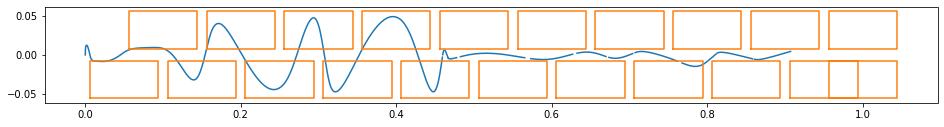

In [18]:
fig = plt.figure(figsize=(16, 2))
ax = fig.subplots(1, 1)
ax.set_aspect('equal')
x, y = zip(*w.points)
ax.plot(x, y)
sole = None
for fs in w.footsteps:
    s = np.array([[-0.044, -.024], [0.044, -.024], [0.044, .024], [-0.044, .024], [-0.044, -.024]]) + fs
    if sole is None:
        sole = s
    else:
        sole = np.vstack([sole, np.array([np.nan, np.nan]), s])
xs, ys = zip(*sole)
ax.plot(xs, ys)